<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Raleway:wght@100&display=swap" rel="stylesheet">

<h1 style="text-transform: uppercase; text-align: center; font-weight: 100;">
Regression in Tensorflow using RNN</h1>
<p style="text-align: center; font-weight: 100;">Predicting Volkswagen car prices</p><br/>

Project requirements:
- Only requirement is: minimum 10k rows
- Any type of neural network - classical but convolutional and recurrent, better grade
- Presentation of project, beside practical questions about model there would be also theoretical.
The topic is free.

Theory required for project presentation:
- Practical side.
- Discuss the scheme of an artificial neuron.
- Activation function, why it is so important.
- Explain how does neuron learn - steps, algorithm?
- How does basic neural network work? (The more you know the better, as well as more complex).
- Discuss the algorithm of neural network using backpropagation learning method. (metoda wstecznej propagacji błędów)
- What subsets and why are the data divided into?
Knowledge of ML, statistics.

Data source: data were taken from the popular Polish automotive website Otomoto (https://www.otomoto.pl/).
https://www.asimovinstitute.org/neural-network-zoo/

1. Import libraries and create dataframe:

In [15]:
import sklearn as sl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from scipy.stats import pearsonr
import tensorflow as tf
import keras.utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from tabulate import tabulate

# from model import VolkswagenModel
# from colorama import init, Fore, Style

print(f"numpy: {np.__version__}, pandas: {pd.__version__}, tensorflow: {tf.__version__}, matplotlib: {mpl.__version__}, seaborn: {sns.__version__}, statsmodels: {sm.__version__}, sklearn: {sl.__version__}")
print("Libs loaded.")

numpy: 1.23.2, pandas: 1.4.4, tensorflow: 2.11.0, matplotlib: 3.5.3, seaborn: 0.12.1, statsmodels: 0.13.2, sklearn: 1.0.2
Libs loaded.


In [16]:
data = pd.read_csv("./data/otomoto.csv")
df = pd.DataFrame(data)
df = df.drop(df.columns[0], axis=1)
df.columns = ['Price', 'Year', 'Mileage', 'Tank capacity', 'Fuel type', 'Model', 'Estimation']
print("Data technical info")
df.info()
df

Data technical info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14915 entries, 0 to 14914
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Price          14915 non-null  int64
 1   Year           14915 non-null  int64
 2   Mileage        14915 non-null  int64
 3   Tank capacity  14915 non-null  int64
 4   Fuel type      14915 non-null  int64
 5   Model          14915 non-null  int64
 6   Estimation     14915 non-null  int64
dtypes: int64(7)
memory usage: 815.8 KB


,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
2,364510,2022,5400,1968,7,8,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
...,...,...,...,...,...,...,...
14910,119500,2020,52000,1498,1,41,2
14911,31000,2002,511000,2461,7,9,0
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2


In [17]:
description = df.describe()
description

,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
count,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000
mean,61420.578478,2012.424137,172886.681931,1755.932618,4.436876,27.893530,1.410325
std,61593.454821,6.757177,100170.759677,395.745487,2.952525,13.300906,1.071621
min,1500.000000,1958.000000,1.000000,77.000000,1.000000,1.000000,0.000000
25%,20000.000000,2008.000000,104343.000000,1498.000000,1.000000,16.000000,0.000000
50%,41999.000000,2013.000000,177000.000000,1896.000000,7.000000,32.000000,2.000000
75%,82900.000000,2018.000000,234350.000000,1968.000000,7.000000,39.000000,2.000000
max,570000.000000,2023.000000,700000.000000,5998.000000,7.000000,50.000000,3.000000


In [18]:
check = 14915
flag = True
for i in range(description.shape[1]):
    if description.iloc[0, i] != check:
        print("Number of occurrences of data is not equal for every label.")
        print(f"Problem at cell: (0, {i})")
        flag = False
        continue
    else:
        print(f"Checked: (0, {i})")

print("All columns passed" if flag == True else "Not passed")

Checked: (0, 0)
Checked: (0, 1)
Checked: (0, 2)
Checked: (0, 3)
Checked: (0, 4)
Checked: (0, 5)
Checked: (0, 6)
All columns passed


2. Clean data:

    Data was cleaned previously in 'scratchpad.py' file and now all the records are represented by integers(documentation of each column values is located in 'model.py' file). Values ​​of 0 represent an error in reading data. Column "Estimation" contains a lot of 0 values, but this is due to the fact that not every article on the website contained such information.

In [19]:
if df.isna().any().any():
    df = df.dropna()
    print("All rows with NaN values were dropped")
else:
    print("0 NaN values")

cols_to_check = df.columns[df.columns != 'Estimation']
if df[cols_to_check].eq(0).any().any():
    df[cols_to_check] = df[cols_to_check].replace(0, np.nan)
    print("All rows with 0 values were dropped")
else:
    print("0 zero values")

0 NaN values
0 zero values


In [20]:
df

,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
2,364510,2022,5400,1968,7,8,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
...,...,...,...,...,...,...,...
14910,119500,2020,52000,1498,1,41,2
14911,31000,2002,511000,2461,7,9,0
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2



Getting know data, analyzing dependencies


Histograms

In [21]:
def make_hist(col_name, bins_val):
    min = df[col_name].min()
    max = df[col_name].max()
    print(f"Lowest {col_name} value: {min}. Highest {col_name} value: {max}.")
    plot_hist = df[col_name].plot.hist(bins=bins_val, grid=True)
    plot_hist.set_title(f"Represents number of cars for each production {col_name.upper()} category")
    plot_hist.set_xlabel(f"{col_name}")
    plot_hist.set_ylabel("Number of observations")
    plt.show()

Lowest Price value: 1500. Highest Price value: 570000.


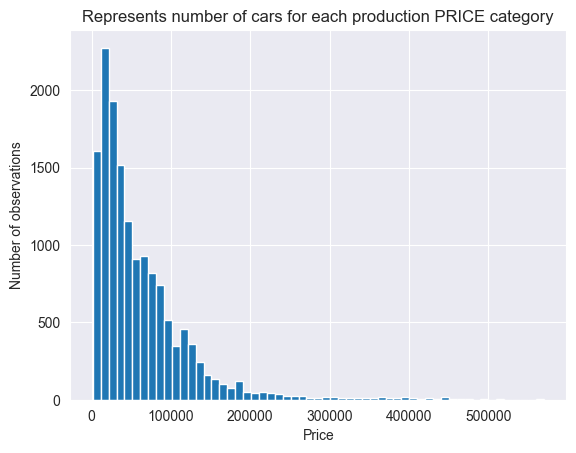

In [22]:
make_hist("Price", 57)

Lowest Year value: 1958. Highest Year value: 2023.


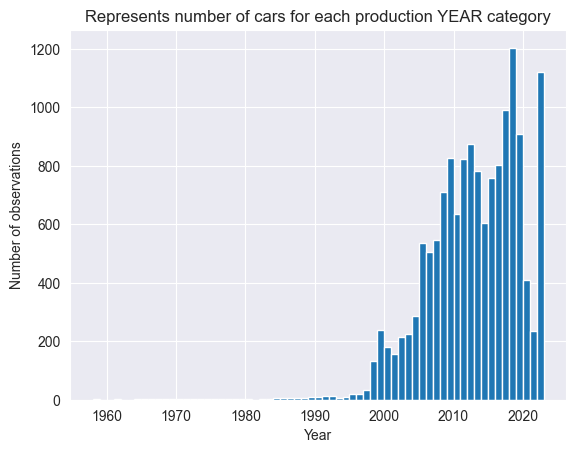

In [23]:
min = df["Year"].min()
max = df["Year"].max()
make_hist("Year", max-min)

Lowest Mileage value: 1. Highest Mileage value: 700000.


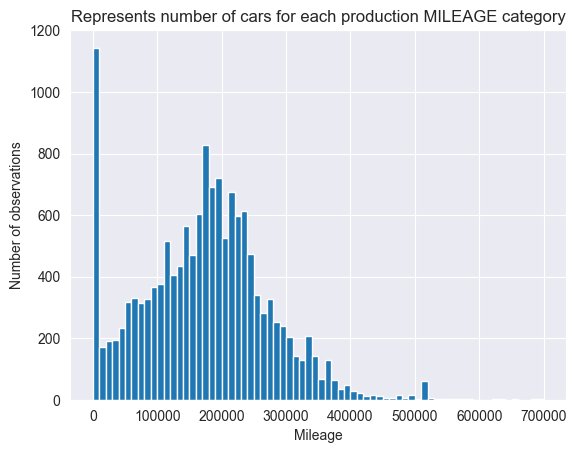

In [24]:
make_hist("Mileage", 70)

Lowest Tank capacity value: 77. Highest Tank capacity value: 5998.


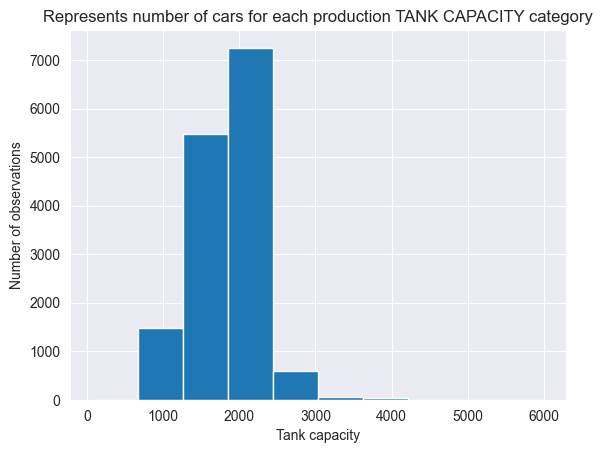

In [25]:
make_hist("Tank capacity", 10) # default bins = 10

# Trzeba jeszcze dopasować przedziały

Lowest Fuel type value: 1. Highest Fuel type value: 7.


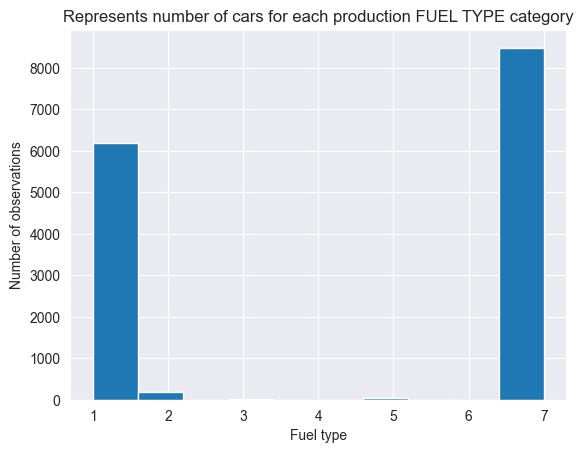

In [26]:
make_hist("Fuel type", 10) # default bins = 10

In [27]:
NO_cars_fuel = df['Fuel type'].value_counts().reset_index()
NO_cars_fuel = NO_cars_fuel.rename(columns={'index': 'type of fuel', 'Fuel type': 'NO of cars with specific fuel type'})
# NaN
# d = {"Benzyna": 1, "Benzyna+LPG": 2, "Benzyna+CNG": 3, "Elektryczny": 4, "Hybryda": 5, "Wodór": 6, "Diesel": 7}
# unique_values['name of fuel'] = unique_values['type of fuel'].map(d)
NO_cars_fuel

,type of fuel,NO of cars with specific fuel type
0,7,8483
1,1,6191
2,2,184
3,5,32
4,3,24
5,4,1


Lowest Model value: 1. Highest Model value: 50.


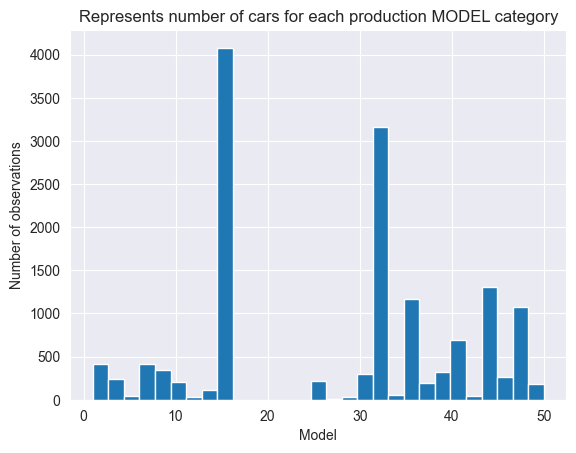

In [28]:
make_hist("Model", 29)

Lowest Estimation value: 0. Highest Estimation value: 3.


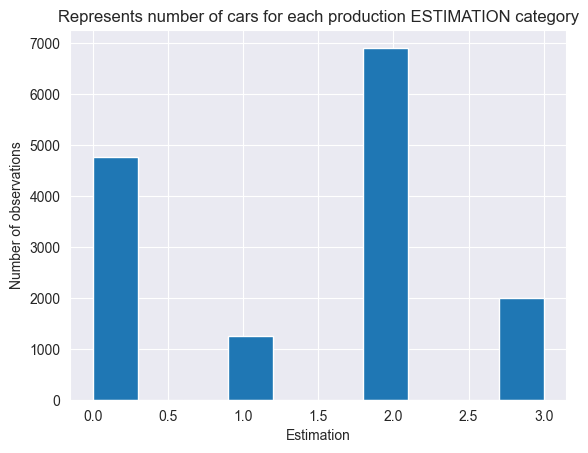

In [29]:
make_hist("Estimation", 10) # default bins = 10

Distribution of cars per column per certain category from column in numbers.

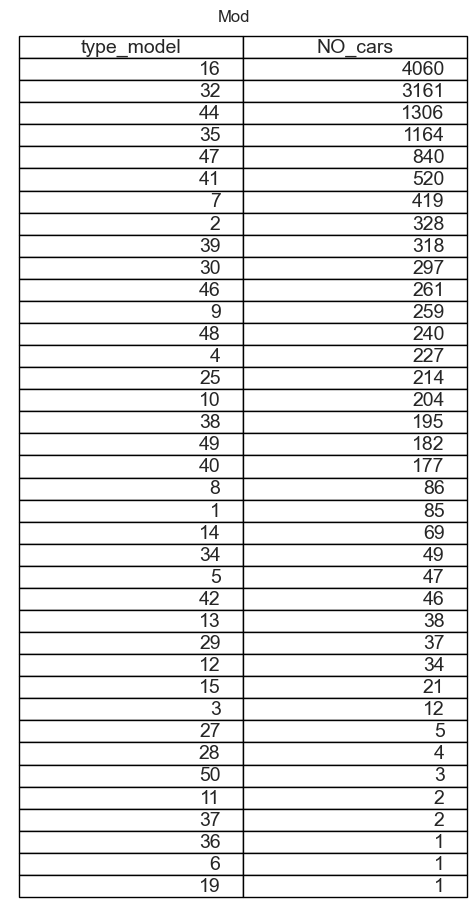

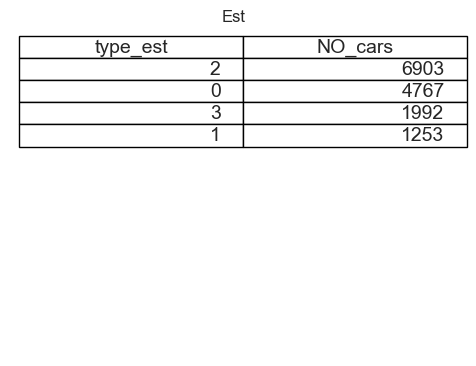

In [30]:
# pr = df['Price'].value_counts().reset_index()
# yr = df['Year'].value_counts().reset_index()
# mil = df['Mileage'].value_counts().reset_index()
# tank = df['Tank capacity'].value_counts().reset_index()
# fuel = df['Fuel type'].value_counts().reset_index()
mod = df['Model'].value_counts().reset_index()
est = df['Estimation'].value_counts().reset_index()

# pr = pr.rename(columns={'index': 'price_cat', 'Price': 'NO_cars'})
# yr = yr.rename(columns={'index': 'year_cat', 'Year': 'NO_cars'})
# mil = mil.rename(columns={'index': 'mileage_cat', 'Mileage': 'NO_cars'})
# tank = tank.rename(columns={'index': 'tank_capacity', 'Tank capacity': 'NO_cars'})
# fuel = fuel.rename(columns={'index': 'type_fuel', 'Fuel type': 'NO_cars'})
mod = mod.rename(columns={'index': 'type_model', 'Model': 'NO_cars'})
est = est.rename(columns={'index': 'type_est', 'Estimation': 'NO_cars'})

def create_table(table_data, table_title):
    fig = plt.figure()
    table = plt.table(cellText=table_data.values, colLabels=table_data.columns, loc='upper left')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 1.5)
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.title(table_title)
    plt.axis('off')
    return fig

# table1 = create_table(pr, "Pr")
# table2 = create_table(yr, "Yr")
# table3 = create_table(mil, "Mil")
# table4 = create_table(tank, "Tank")
# table5 = create_table(fuel, "Fuel")
table6 = create_table(mod, "Mod")
table7 = create_table(est, "Est")

Box plots

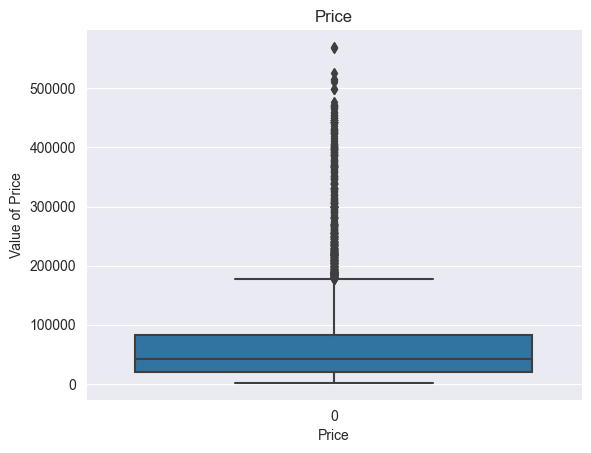

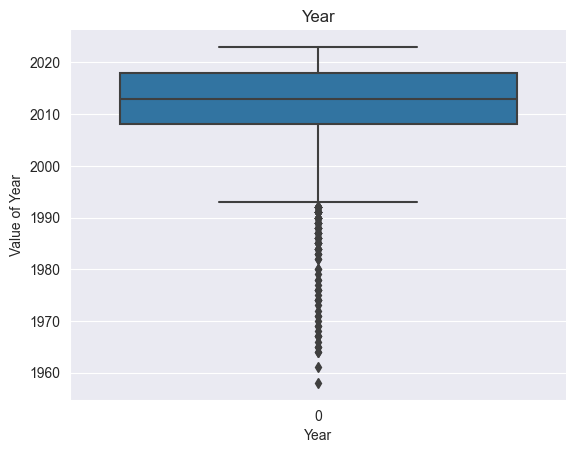

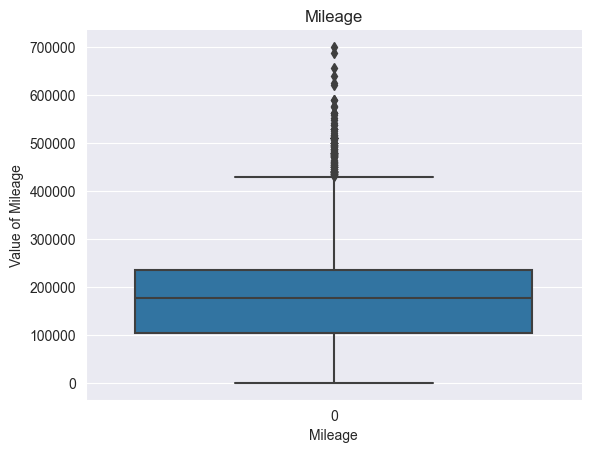

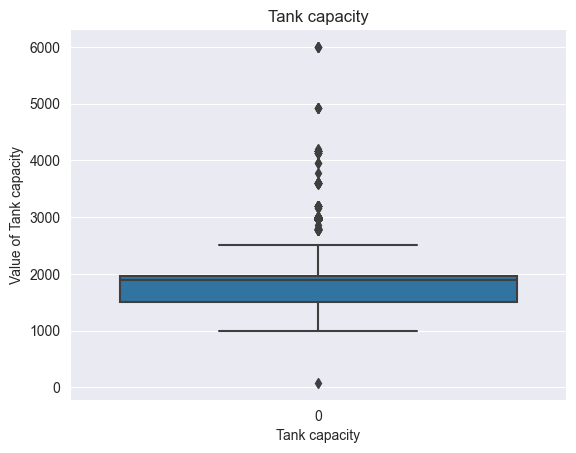

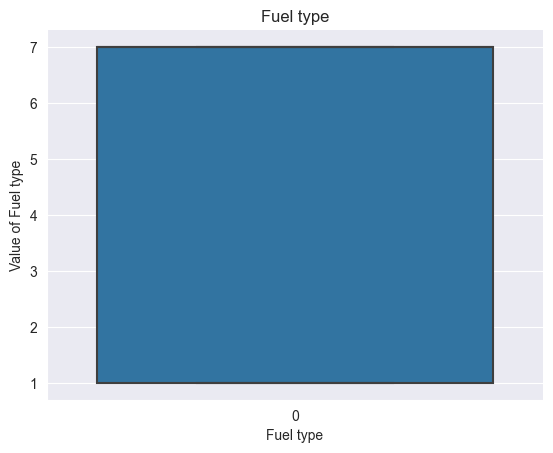

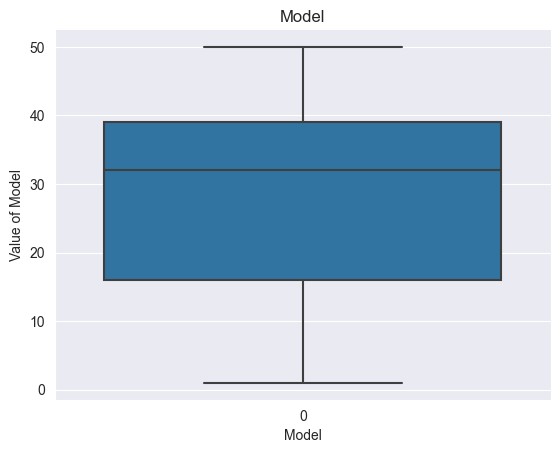

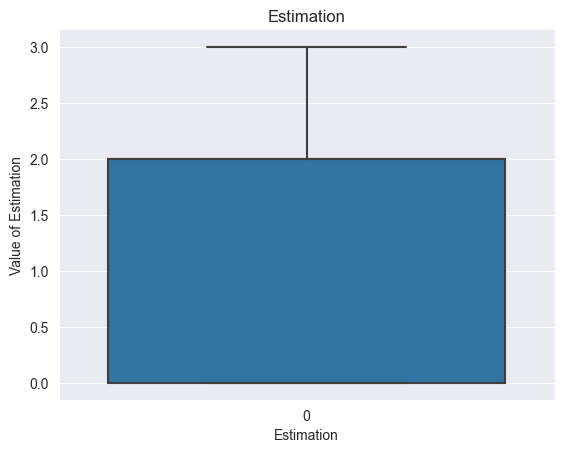

In [31]:
for i, column in enumerate(df.columns):
    fig, ax = plt.subplots()
    sns.boxplot(data=df[column], ax=ax).set(title=f"{column.upper()} boxplot", xlabel=f"{column}", ylabel=f"Value of {column}")
    ax.set_title(column)
    sns.despine()
    plt.show()

Heat Map

<AxesSubplot:>

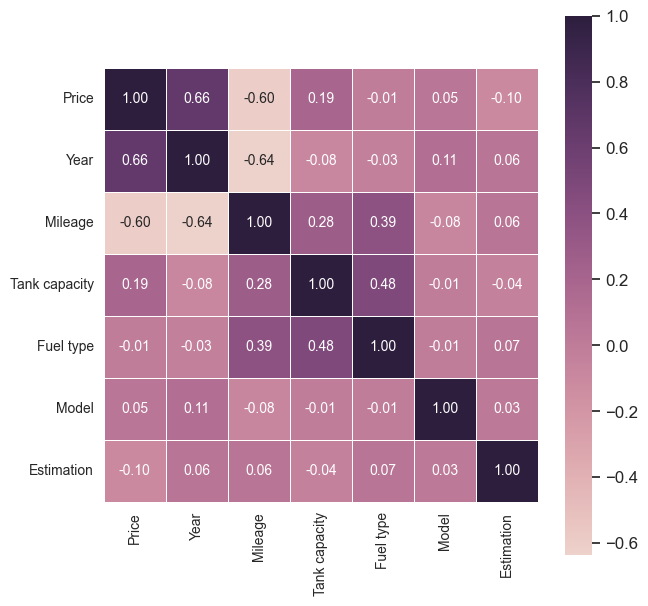

In [32]:
correlation_matrix = np.corrcoef(df.values.T)

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.1)
sns.heatmap(data=correlation_matrix, square=True, cbar=True, annot=True, annot_kws={'size': 10}, xticklabels=df.columns, yticklabels=df.columns, fmt=".2f", linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))

Outlier detection

In [33]:
# https://www.kaggle.com/code/durgeshrao9993/removing-outliers-by-iqr-method

# # Interquartile Range (IQR)
# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR = Q3 - Q1
# data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Calculate the z-scores of each column - measure that represents the number of standard deviations a data point is from the mean of the dataset
z_scores = (df - df.mean()) / df.std()
# Set the threshold for the z-score
threshold = 3
# Remove any rows where the z-score is greater than the threshold
df = df[(np.abs(z_scores) < threshold).all(axis=1)]
df

,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
5,139900,2020,149000,1968,7,32,3
...,...,...,...,...,...,...,...
14909,88999,2018,179960,1968,7,16,2
14910,119500,2020,52000,1498,1,41,2
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2


In [34]:
print(f"14915 dropped to {df.shape[0]} rows")

14915 dropped to 14105 rows


Boxplot / Heat Map - after outlier detection

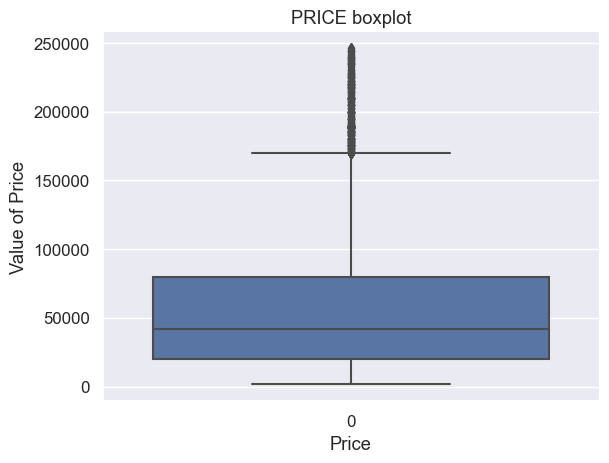

In [35]:
sns.boxplot(df['Price']).set(title="PRICE boxplot", xlabel="Price", ylabel="Value of Price")
sns.despine()

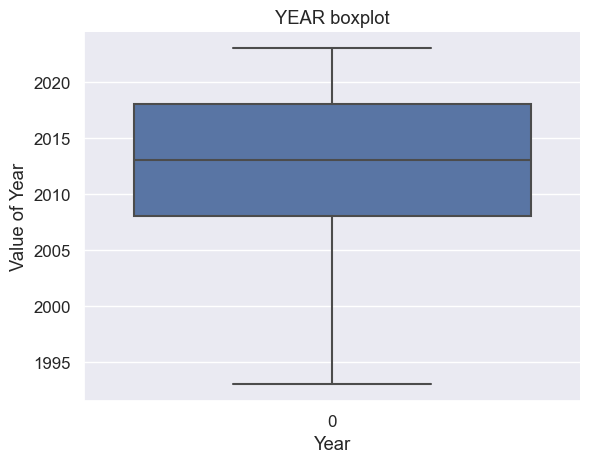

In [36]:
sns.boxplot(df['Year']).set(title="YEAR boxplot", xlabel="Year", ylabel="Value of Year")
sns.despine()

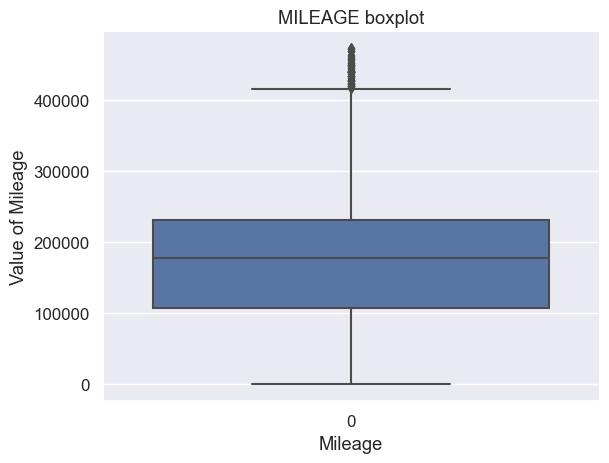

In [37]:
sns.boxplot(df['Mileage']).set(title="MILEAGE boxplot", xlabel="Mileage", ylabel="Value of Mileage")
sns.despine()

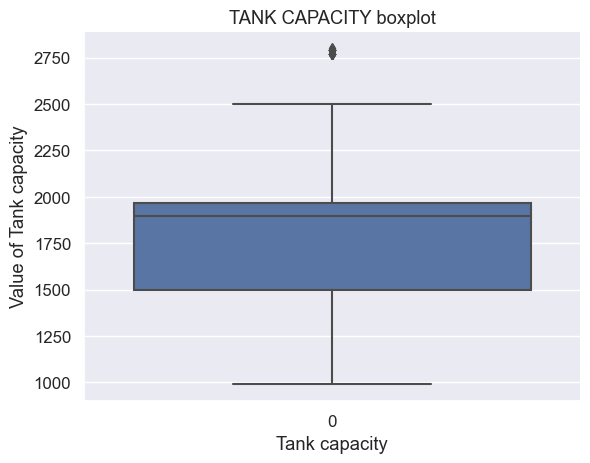

In [38]:
sns.boxplot(df['Tank capacity']).set(title="TANK CAPACITY boxplot", xlabel="Tank capacity", ylabel="Value of Tank capacity")
sns.despine()

<AxesSubplot:>

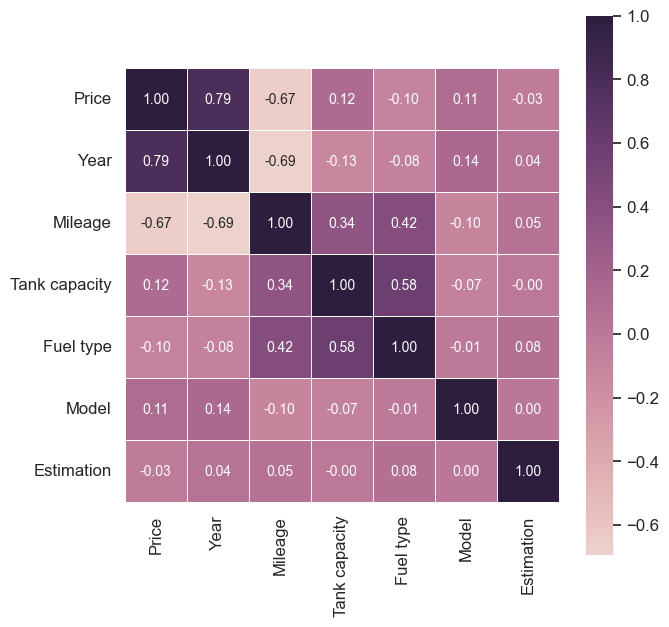

In [39]:
correlation_matrix = np.corrcoef(df.values.T)

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.1)
sns.heatmap(data=correlation_matrix, square=True, cbar=True, annot=True, annot_kws={'size': 10}, xticklabels=df.columns, yticklabels=df.columns, fmt=".2f", linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))

Pair plot

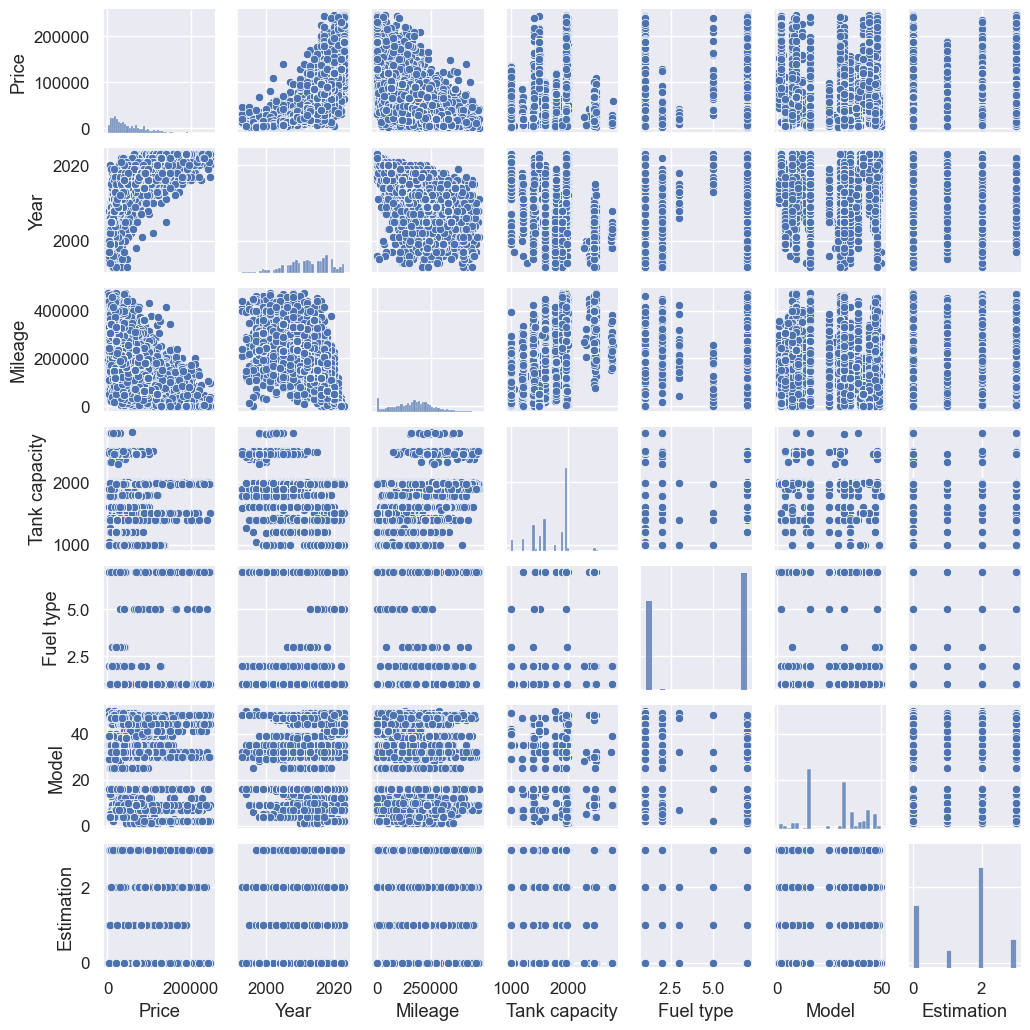

In [40]:
sns.pairplot(df, height=1.5)

Splitting data into sets

In [41]:
# SKLEARN

X = df.drop(['Price'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [42]:
# KERAS/TENSORFLOW

# data_size = len(df)
# test_size = int(data_size * 0.2)  # 20% danych przeznaczamy na zbiór testowy
# train_size = data_size - test_size
#
# data = tf.data.Dataset.from_tensor_slices((X.values, y.values))
# data = data.shuffle(buffer_size=data_size, reshuffle_each_iteration=True) # randomize data after each iteration (epoch)
#
# # Helps to optimize code by dividing datasets into batches, portion of data instead of individual processing.
# train_data = data.take(train_size).batch(32)
# test_data = data.skip(train_size).take(test_size).batch(32)
# X_train, y_train = next(iter(train_data))
# X_test, y_test = next(iter(test_data))
#
# # Print length of datasets portions
# print(f"X_train len = {len(X_train)}")
# print(f"y_train len = {len(y_train)}")
# print(f"X_test len = {len(X_test)}")
# print(f"y_test len = {len(y_test)}")
#
# # Print datasets portions
# # print('X_train = ', X_train)
# # print('y_train = ', y_train)
# # print('X_test = ', X_test)
# # print('y_test = ', y_test)

Model Architecture

In [43]:
# https://www.tensorflow.org/guide/keras/rnn?hl=pl
# https://www.ibm.com/topics/recurrent-neural-networks
# Pipelines


def LSTM_architecture(neurons_lstm, neurons_dense, activation, l2_val):
    model_LSTM = tf.keras.Sequential([
        tf.keras.layers.LSTM(neurons_lstm, input_shape=(1, X_train.shape[-1])),
        tf.keras.layers.Dense(neurons_dense, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_val)),
        tf.keras.layers.Dense(neurons_dense, activation=activation),
        tf.keras.layers.Dense(1)
    ])
    model_LSTM.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    return model_LSTM

def MLP_architecture(neurons_lstm, neurons_dense1, neurons_dense2, activation, l2_val):
    modelMLP = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_lstm, input_shape=(X_train.shape[1],), activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense1, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense2, activation=activation),
        tf.keras.layers.Dense(1)
    ])
    return modelMLP

def GRU_architecture(neurons_lstm=128, neurons_dense=64, activation='relu', l2_val=0.01):
    model_GRU = tf.keras.Sequential([
        tf.keras.layers.GRU(neurons_lstm, input_shape=(1, X_train.shape[-1])),
        tf.keras.layers.Dense(neurons_dense, activation=activation , kernel_regularizer=tf.keras.regularizers.l2(l2_val)),
        tf.keras.layers.Dense(1)
    ])
    model_GRU.compile(
        optimizer='adam',
        loss='mse'
    )
    return model_GRU

def MLP_architecture_v2(neurons_lstm, neurons_dense1, neurons_dense2, neurons_dense3, neurons_dense4, activation, l2_val):
    modelMLPv2 = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_lstm, input_shape=(X_train.shape[1],), activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense1, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense2, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense3, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense4, activation=activation),
        tf.keras.layers.Dense(1)
    ])
    modelMLPv2.compile(loss='mse', optimizer='adam')
    return modelMLPv2


# Equivalent to:
# input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm_layer = tf.keras.layers.LSTM(64)(input_layer)
# dense_layer_1 = tf.keras.layers.Dense(32, activation='relu')(lstm_layer)
# output_layer = tf.keras.layers.Dense(1)(dense_layer_1)
# model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Normalize / Scale

In [44]:
# Normalization - we change the distribution of data, not the range of data like it is done in scaling. The point is to change observations so that they can be described as a normal distribution.
# Normalization should be done after splitting into train and test data sets.
# https://keras.io/api/layers/preprocessing_layers/numerical/normalization/
# fit_transform() is used to learn and apply the transformation to the data in one step, whereas transform() is used to apply the transformation to new data using the learned parameters.

# If you are using a regression model and want to predict a continuous target variable (i.e., y), then you should scale both the input features (X) and the target variable (y). This is because scaling both the input features and target variable will help the model to learn better and converge faster.
# If you are using a classification model and want to predict a binary or categorical target variable, then you do not need to scale the target variable (y). This is because scaling does not change the nature of the target variable, and most classification algorithms do not depend on the scale of the target variable.


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
print("Normalization done")

Normalization done


Compile and train training the model

In [45]:
# Reshape 2D array into 3D tensor
X_train_3D = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3D = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [46]:
model_LSTM = LSTM_architecture(neurons_lstm=64, neurons_dense=32, activation='relu', l2_val=0.01)


# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_LSTM = model_LSTM.fit(
    X_train_3D,
    y_train_scaled,
    epochs=5,
    validation_data=(X_test_3D, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
353/353 [==============================] - 6s 7ms/step - loss: 0.3981 - val_loss: 0.2130
Epoch 2/5
353/353 [==============================] - 1s 4ms/step - loss: 0.1763 - val_loss: 0.1764
Epoch 3/5
353/353 [==============================] - 2s 5ms/step - loss: 0.1568 - val_loss: 0.1649
Epoch 4/5
353/353 [==============================] - 2s 4ms/step - loss: 0.1474 - val_loss: 0.1598
Epoch 5/5
353/353 [==============================] - 1s 4ms/step - loss: 0.1441 - val_loss: 0.1573


In [47]:
model_MLP = MLP_architecture(neurons_lstm=128, neurons_dense1=64, neurons_dense2=32, activation='relu', l2_val=0.01)
model_MLP.compile(
    optimizer='adam',
    loss='mse'
)
# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_MLP = model_MLP.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=5,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
353/353 [==============================] - 3s 4ms/step - loss: 0.1897 - val_loss: 0.1402
Epoch 2/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1299 - val_loss: 0.1294
Epoch 3/5
353/353 [==============================] - 1s 4ms/step - loss: 0.1255 - val_loss: 0.1368
Epoch 4/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1226 - val_loss: 0.1355
Epoch 5/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1175 - val_loss: 0.1227


In [48]:
model_GRU = GRU_architecture(neurons_lstm=128, neurons_dense=64, activation='relu', l2_val=0.01)


# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_GRU = model_GRU.fit(
    X_train_3D,
    y_train_scaled,
    epochs=5,
    validation_data=(X_test_3D, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
353/353 [==============================] - 5s 6ms/step - loss: 0.4653 - val_loss: 0.2183
Epoch 2/5
353/353 [==============================] - 2s 4ms/step - loss: 0.1850 - val_loss: 0.1873
Epoch 3/5
353/353 [==============================] - 1s 4ms/step - loss: 0.1661 - val_loss: 0.1752
Epoch 4/5
353/353 [==============================] - 1s 4ms/step - loss: 0.1585 - val_loss: 0.1693
Epoch 5/5
353/353 [==============================] - 1s 4ms/step - loss: 0.1509 - val_loss: 0.1715


In [49]:
model_MLP_more_neurons = MLP_architecture(neurons_lstm=128, neurons_dense1=128, neurons_dense2=64, activation='relu', l2_val=0.01)
model_MLP_more_neurons.compile(
optimizer = 'adam',
loss = 'mse'
)
# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_MLP_more_neurons = model_MLP_more_neurons.fit(
X_train_scaled,
y_train_scaled,
epochs = 5,
validation_data = (X_test_scaled, y_test_scaled),
batch_size = 32,
validation_split = 0.2
)

Epoch 1/5
353/353 [==============================] - 2s 3ms/step - loss: 0.1758 - val_loss: 0.1532
Epoch 2/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1307 - val_loss: 0.1470
Epoch 3/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1233 - val_loss: 0.1368
Epoch 4/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1225 - val_loss: 0.1249
Epoch 5/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1187 - val_loss: 0.1242


In [50]:
model_MLP_v2 = MLP_architecture_v2(neurons_lstm=128, neurons_dense1=64, neurons_dense2=32, neurons_dense3=16, neurons_dense4=16, activation='relu', l2_val=0.01)
model_MLP_v2.compile(
    optimizer='adam',
    loss='mse'
)
history_MLP_v2 = model_MLP_v2.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=5,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
353/353 [==============================] - 3s 4ms/step - loss: 0.2240 - val_loss: 0.1482
Epoch 2/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1400 - val_loss: 0.1624
Epoch 3/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1301 - val_loss: 0.1269
Epoch 4/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1237 - val_loss: 0.1274
Epoch 5/5
353/353 [==============================] - 1s 3ms/step - loss: 0.1231 - val_loss: 0.1336


In [51]:
# We could also add combination of MLP and CNN.

Evaluating the model

In [52]:
print("---------- LSTM MODEL ----------")

test_loss_LSTM = model_LSTM .evaluate(X_test_3D, y_test_scaled)
train_loss_LSTM = model_LSTM.evaluate(X_train_3D, y_train_scaled)

y_train_pred_LSTM_scaled = model_LSTM.predict(X_train_3D)
y_test_pred_LSTM_scaled = model_LSTM.predict(X_test_3D)

y_train_pred_LSTM = scaler.inverse_transform(y_train_pred_LSTM_scaled)
y_test_pred_LSTM = scaler.inverse_transform(y_test_pred_LSTM_scaled)

rmse_train_LSTM = np.sqrt(mean_squared_error(y_train, y_train_pred_LSTM))
rmse_test_LSTM = np.sqrt(mean_squared_error(y_test, y_test_pred_LSTM))

mae_train_LSTM = mean_absolute_error(y_train, y_train_pred_LSTM)
mae_test_LSTM = mean_absolute_error(y_test, y_test_pred_LSTM)

corr_train_LSTM = np.corrcoef(y_train.T, y_train_pred_LSTM.T)[0, 1]
corr_test_LSTM = np.corrcoef(y_test.T, y_test_pred_LSTM.T)[0, 1]

mpe_train_LSTM = mean_absolute_percentage_error(y_train, y_train_pred_LSTM)
mpe_test_LSTM = mean_absolute_percentage_error(y_test, y_test_pred_LSTM)

print("LSTM done")

---------- LSTM MODEL ----------
89/89 [==============================] - 0s 2ms/step
Testing Loss =  0.1573
Training Loss = 0.1488
Testing RMSE =  17722.2184
Training RMSE = 17206.3619
Testing MAE =  10758.8048
Training MAE = 10495.0091
Testing Pearson Correlation Coefficient = 0.9282
Training Pearson Correlation Coefficient = 0.9351
Testing Mean Absolute Percentage Error = 0.2590
Training Mean Absolute Percentage Error = 0.2587


In [53]:
print("---------- MLP MODEL ----------")

test_loss_MLP = model_MLP.evaluate(X_test_scaled, y_test_scaled)
train_loss_MLP = model_MLP.evaluate(X_train_scaled, y_train_scaled)

y_train_pred_MLP_scaled = model_MLP.predict(X_train_scaled)
y_test_pred_MLP_scaled = model_MLP.predict(X_test_scaled)

y_train_pred_MLP = scaler.inverse_transform(y_train_pred_MLP_scaled)
y_test_pred_MLP = scaler.inverse_transform(y_test_pred_MLP_scaled)

rmse_train_MLP = np.sqrt(mean_squared_error(y_train, y_train_pred_MLP))
rmse_test_MLP = np.sqrt(mean_squared_error(y_test, y_test_pred_MLP))

mae_train_MLP = mean_absolute_error(y_train, y_train_pred_MLP)
mae_test_MLP = mean_absolute_error(y_test, y_test_pred_MLP)

corr_train_MLP = np.corrcoef(y_train.T, y_train_pred_MLP.T)[0, 1]
corr_test_MLP = np.corrcoef(y_test.T, y_test_pred_MLP.T)[0, 1]

mpe_train_MLP = mean_absolute_percentage_error(y_train, y_train_pred_MLP)
mpe_test_MLP = mean_absolute_percentage_error(y_test, y_test_pred_MLP)

print("MLP done")

---------- MLP MODEL ----------
89/89 [==============================] - 0s 2ms/step
Testing Loss =  0.1227
Training Loss = 0.1116
Testing RMSE =  16105.3306
Training RMSE = 15363.8896
Testing MAE =  9608.7178
Training MAE = 9191.6179
Testing Pearson Correlation Coefficient = 0.9376
Training Pearson Correlation Coefficient = 0.9431
Testing Mean Absolute Percentage Error = 0.2270
Training Mean Absolute Percentage Error = 0.2378


In [54]:
print("---------- GRU MODEL ----------")
test_loss_GRU = model_GRU .evaluate(X_test_3D, y_test_scaled)
train_loss_GRU = model_GRU.evaluate(X_train_3D, y_train_scaled)

y_train_pred_GRU_scaled = model_GRU.predict(X_train_3D)
y_test_pred_GRU_scaled = model_GRU.predict(X_test_3D)

y_train_pred_GRU = scaler.inverse_transform(y_train_pred_GRU_scaled)
y_test_pred_GRU = scaler.inverse_transform(y_test_pred_GRU_scaled)

rmse_train_GRU = np.sqrt(mean_squared_error(y_train, y_train_pred_GRU))
rmse_test_GRU = np.sqrt(mean_squared_error(y_test, y_test_pred_GRU))

mae_train_GRU = mean_absolute_error(y_train, y_train_pred_GRU)
mae_test_GRU = mean_absolute_error(y_test, y_test_pred_GRU)

corr_train_GRU= np.corrcoef(y_train.T, y_train_pred_GRU.T)[0, 1]
corr_test_GRU = np.corrcoef(y_test.T, y_test_pred_GRU.T)[0, 1]

mpe_train_GRU = mean_absolute_percentage_error(y_train, y_train_pred_GRU)
mpe_test_GRU = mean_absolute_percentage_error(y_test, y_test_pred_GRU)
print("GRU done")

---------- GRU MODEL ----------
89/89 [==============================] - 0s 2ms/step
Testing Loss =  0.1715
Training Loss = 0.1560
Testing RMSE =  18446.6762
Training RMSE = 17538.8858
Testing MAE =  11749.6499
Training MAE = 11255.8891
Testing Pearson Correlation Coefficient = 0.9159
Training Pearson Correlation Coefficient = 0.9245
Testing Mean Absolute Percentage Error = 0.2876
Training Mean Absolute Percentage Error = 0.2886


In [55]:
print("---------- MLP_more_neurons MODEL ----------")

test_loss_MLP_n = model_MLP_more_neurons.evaluate(X_test_scaled, y_test_scaled)
train_loss_MLP_n = model_MLP_more_neurons.evaluate(X_train_scaled, y_train_scaled)

y_train_pred_MLP_n_scaled = model_MLP_more_neurons.predict(X_train_scaled)
y_test_pred_MLP_n_scaled = model_MLP_more_neurons.predict(X_test_scaled)

y_train_pred_MLP_n = scaler.inverse_transform(y_train_pred_MLP_n_scaled)
y_test_pred_MLP_n = scaler.inverse_transform(y_test_pred_MLP_n_scaled)

rmse_train_MLP_n = np.sqrt(mean_squared_error(y_train, y_train_pred_MLP_n))
rmse_test_MLP_n = np.sqrt(mean_squared_error(y_test, y_test_pred_MLP_n))

mae_train_MLP_n = mean_absolute_error(y_train, y_train_pred_MLP_n)
mae_test_MLP_n = mean_absolute_error(y_test, y_test_pred_MLP_n)

corr_train_MLP_n = np.corrcoef(y_train.T, y_train_pred_MLP_n.T)[0, 1]
corr_test_MLP_n = np.corrcoef(y_test.T, y_test_pred_MLP_n.T)[0, 1]

mpe_train_MLP_n = mean_absolute_percentage_error(y_train, y_train_pred_MLP_n)
mpe_test_MLP_n = mean_absolute_percentage_error(y_test, y_test_pred_MLP_n)
print("MLP_more_neurons done")

---------- MLP_more_neurons MODEL ----------
89/89 [==============================] - 0s 1ms/step
Testing Mean Absolute Percentage Error = 0.2665
Training Mean Absolute Percentage Error = 0.2674
Testing Loss =  0.1242
Training Loss = 0.1108
Testing RMSE =  16204.2117
Training RMSE = 15303.2301
Testing MAE =  9762.9299
Training MAE = 9369.2892
Testing Pearson Correlation Coefficient = 0.9373
Training Pearson Correlation Coefficient = 0.9444


In [56]:
print("---------- MLP_v2 MODEL ----------")

test_loss_MLP_v2 = model_MLP_v2.evaluate(X_test_scaled, y_test_scaled)
train_loss_MLP_v2 = model_MLP_v2.evaluate(X_train_scaled, y_train_scaled)

y_train_pred_MLP_v2_scaled = model_MLP_v2.predict(X_train_scaled)
y_test_pred_MLP_v2_scaled = model_MLP_v2.predict(X_test_scaled)

y_train_pred_MLP_v2 = scaler.inverse_transform(y_train_pred_MLP_v2_scaled)
y_test_pred_MLP_v2 = scaler.inverse_transform(y_test_pred_MLP_v2_scaled)

rmse_train_MLP_v2 = np.sqrt(mean_squared_error(y_train, y_train_pred_MLP_v2))
rmse_test_MLP_v2 = np.sqrt(mean_squared_error(y_test, y_test_pred_MLP_v2))

mae_train_MLP_v2 = mean_absolute_error(y_train, y_train_pred_MLP_v2)
mae_test_MLP_v2 = mean_absolute_error(y_test, y_test_pred_MLP_v2)

corr_train_MLP_v2 = np.corrcoef(y_train.T, y_train_pred_MLP_v2.T)[0, 1]
corr_test_MLP_v2 = np.corrcoef(y_test.T, y_test_pred_MLP_v2.T)[0, 1]

mpe_train_MLP_v2 = mean_absolute_percentage_error(y_train, y_train_pred_MLP_v2)
mpe_test_MLP_v2 = mean_absolute_percentage_error(y_test, y_test_pred_MLP_v2)
print('MLP_v2 done')

---------- MLP_v2 MODEL ----------
89/89 [==============================] - 0s 2ms/step
Testing Loss =  0.1336
Training Loss = 0.1175
Testing RMSE =  16804.4643
Training RMSE = 15762.3514
Testing MAE =  10030.2306
Training MAE = 9485.3704
Testing Pearson Correlation Coefficient = 0.9346
Training Pearson Correlation Coefficient = 0.9420
Testing Mean Absolute Percentage Error = 0.2393
Training Mean Absolute Percentage Error = 0.2520


In [65]:
LSTM_eval = [test_loss_LSTM, train_loss_LSTM, rmse_test_LSTM, rmse_train_LSTM, mae_test_LSTM,mae_train_LSTM, corr_test_LSTM, corr_train_LSTM, mpe_test_LSTM, mpe_train_LSTM]
MLP_eval = [test_loss_MLP, train_loss_MLP, rmse_test_MLP, rmse_train_MLP, mae_test_MLP, mae_train_MLP, corr_test_MLP, corr_train_MLP, mpe_test_MLP, mpe_train_MLP]
GRU_eval = [test_loss_GRU, train_loss_GRU, rmse_test_GRU, rmse_train_GRU, mae_test_GRU, mae_train_GRU, corr_test_GRU, corr_train_GRU, mpe_test_GRU, mpe_train_GRU]
MLP_n_eval = [test_loss_MLP_n, train_loss_MLP_n, rmse_test_MLP_n, rmse_train_MLP_n, mae_test_MLP_n, mae_train_MLP_n, corr_test_MLP_n, corr_train_MLP_n, mpe_test_MLP_n, mpe_train_MLP_n]
MLP_v2_eval = [test_loss_MLP_v2, train_loss_MLP_v2, rmse_test_MLP_v2, rmse_train_MLP_v2, mae_test_MLP_v2, mae_train_MLP_v2, corr_test_MLP_v2, corr_train_MLP_v2, mpe_test_MLP_v2, mpe_train_MLP_v2]

evaluation_headers = ['Test Loss', 'Train Loss', 'Test RMSE', 'Train RMSE', 'Test MAE', 'Train MAE', 'Test Pearson Coef', 'Train Pearson Coef', "Test % Error", 'Train % Error']
evaldf = pd.DataFrame({'Model': evaluation_headers,
                     'LSTM': LSTM_eval,
                     'MLP': MLP_eval,
                     'GRU': GRU_eval,
                     'MLP_n': MLP_n_eval,
                     'MLP_v2': MLP_v2_eval
                     })
evaldf

,Model,LSTM,MLP,GRU,MLP_n,MLP_v2
0,Test Loss,0.157339,0.122684,0.171457,0.124195,0.133567
1,Train Loss,0.148817,0.111648,0.156005,0.110768,0.117514
2,Test RMSE,17722.218448,16105.330624,18446.676204,16204.211709,16804.464315
3,Train RMSE,17206.361889,15363.889574,17538.885756,15303.230076,15762.351432
4,Test MAE,10758.804800,9608.717833,11749.649902,9762.929915,10030.230648
5,Train MAE,10495.009111,9191.617924,11255.889124,9369.289170,9485.370443
6,Test Pearson Coef,0.928197,0.937557,0.915900,0.937316,0.934641
7,Train Pearson Coef,0.935102,0.943057,0.924487,0.944440,0.941952
8,Test % Error,0.258669,0.237804,0.288580,0.267353,0.252003
9,Train % Error,0.259011,0.226996,0.287611,0.266490,0.239292


Metrics plots

In [57]:
def loss_plots(model_history, model_name):
    # Train and validation loss history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    # Plot the training and validation loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss FOR {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def pred_v_actual_plots(y_pred_model, model_name):
    # Predictions vs. actual values
    plt.scatter(y_test, y_pred_model, color='red', label='Predicted')
    plt.scatter(y_test, y_test, color='blue', label='Actual')
    plt.title(f'Predictions vs. Actual Values FOR {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

def mae_rmse_plots(y_pred_model, model_name, mae_model, rmse_model):
    y_pred_model_flatten = y_pred_model.flatten()
    # Plot the Mean Absolute Error
    plt.scatter(y_test, abs(y_pred_model_flatten - y_test), color='cyan', label='Mean Absolute Error')
    plt.axhline(y=mae_model, color='brown', linestyle='--', label='MAE')
    plt.title(f'Mean Absolute Error FOR {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    # Plot the Root Mean Square Deviation
    plt.scatter(y_test, (y_pred_model_flatten - y_test)**2, color='purple', label='Root Mean Square Error')
    plt.axhline(y=rmse_model, color='yellow', linestyle='--', label='RMSE')
    plt.title(f'Mean Squared Error FOR {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

# https://www.baeldung.com/cs/training-validation-loss-deep-learning

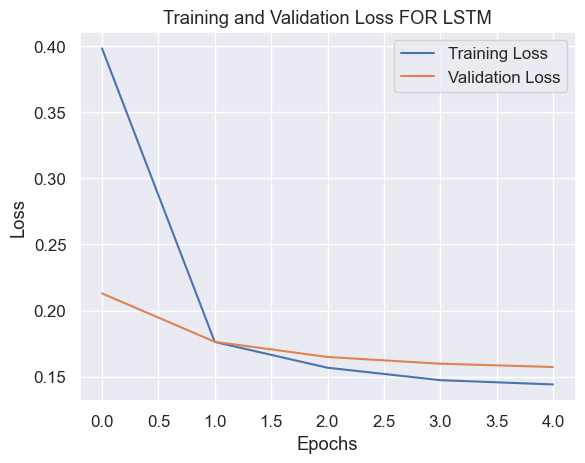

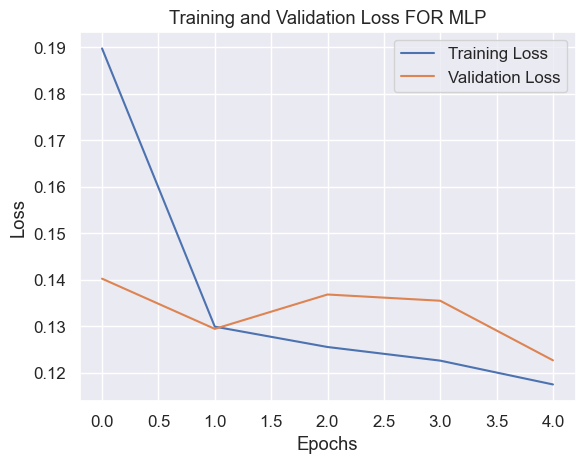

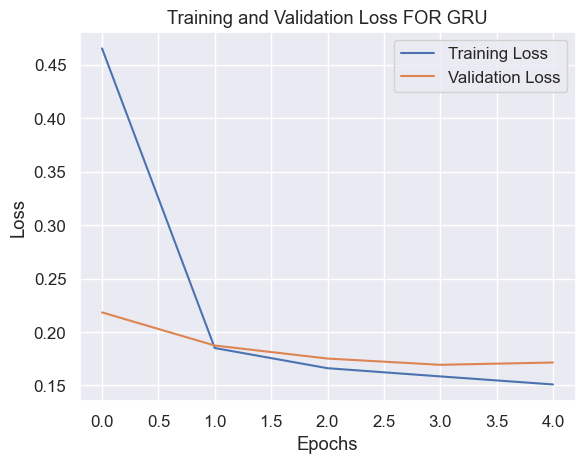

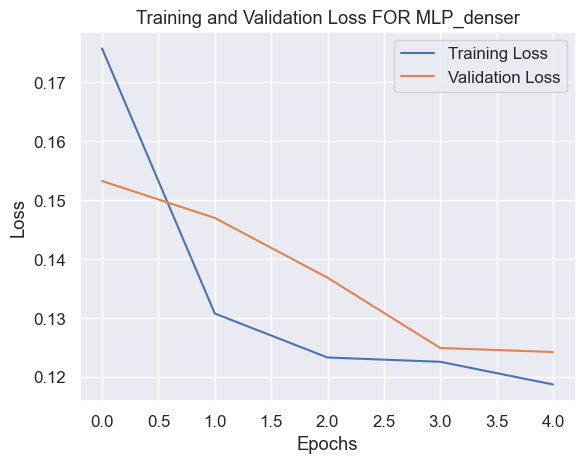

In [58]:
loss_plots(history_LSTM, "LSTM")
loss_plots(history_MLP, "MLP")
loss_plots(history_GRU, "GRU")
loss_plots(history_MLP_more_neurons, "MLP_denser")
# loss_plots(history_MLP_v2, "MLP_v2")

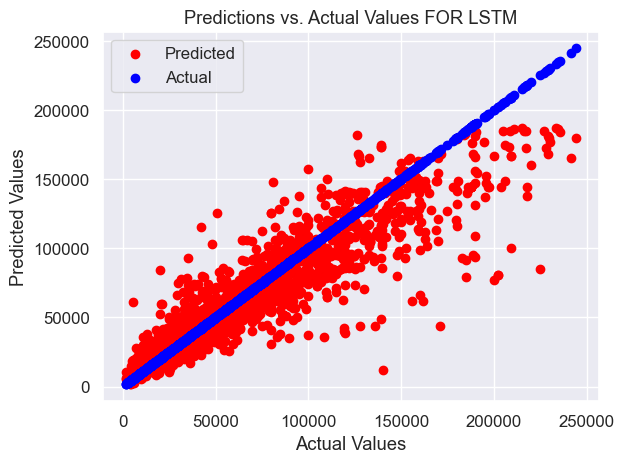

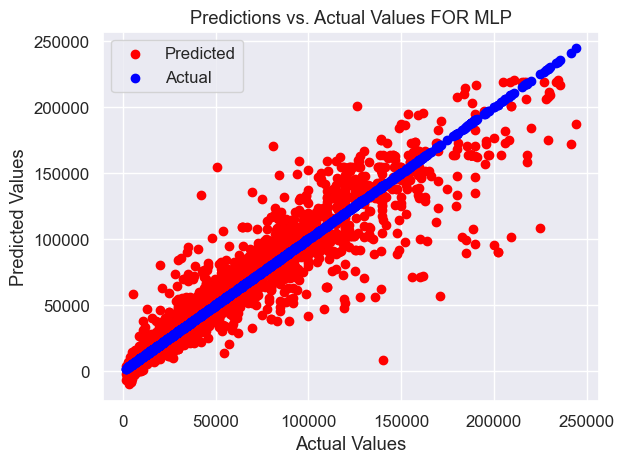

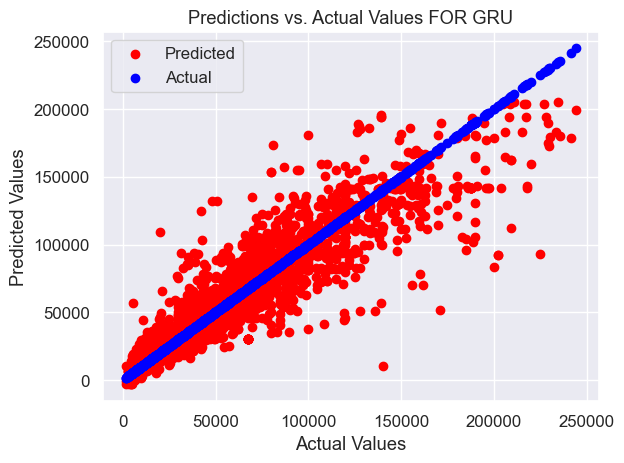

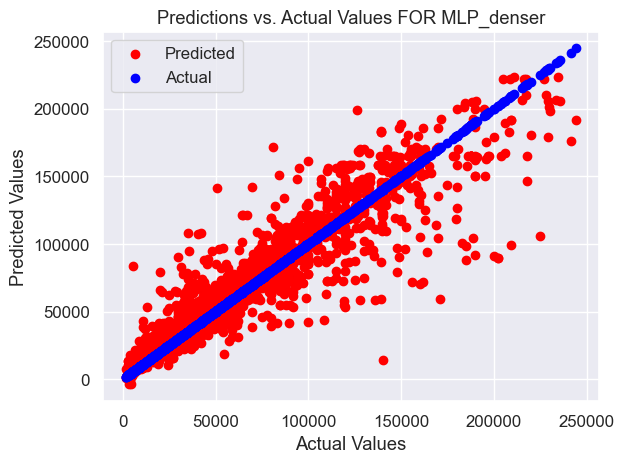

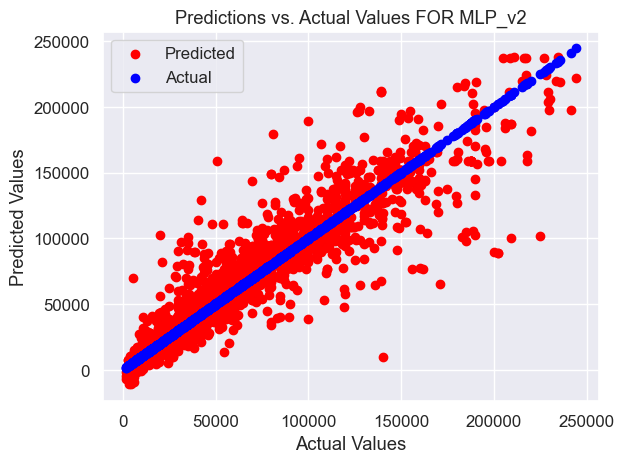

In [59]:
pred_v_actual_plots(y_test_pred_LSTM, "LSTM")
pred_v_actual_plots(y_test_pred_MLP, "MLP")
pred_v_actual_plots(y_test_pred_GRU, "GRU")
pred_v_actual_plots(y_test_pred_MLP_n, "MLP_denser")
pred_v_actual_plots(y_test_pred_MLP_v2, "MLP_v2")

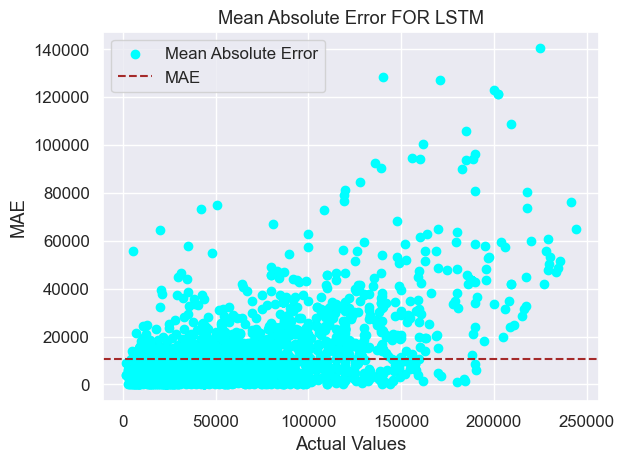

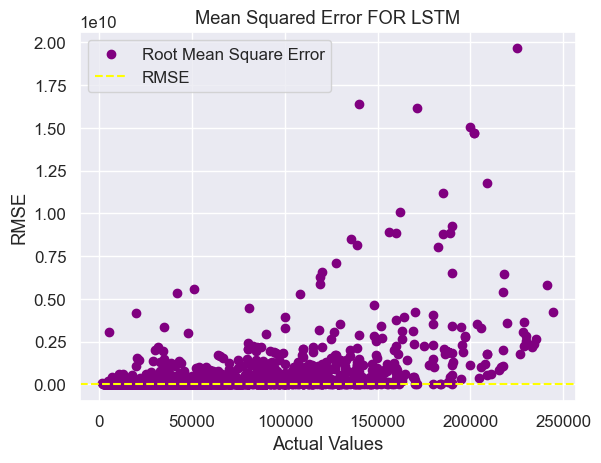

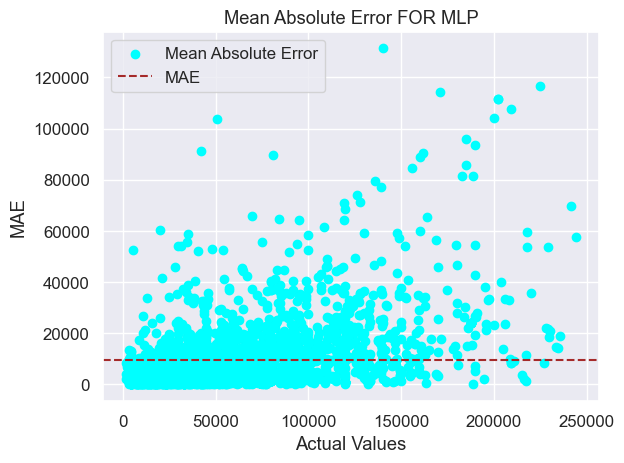

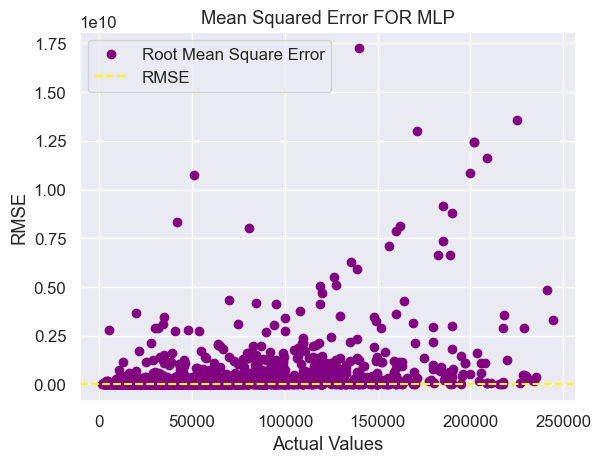

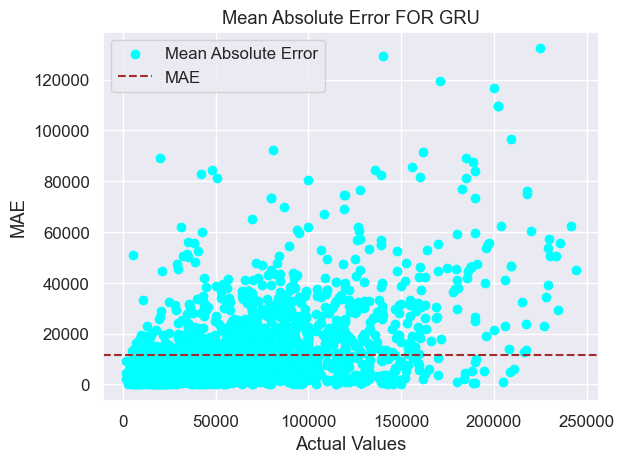

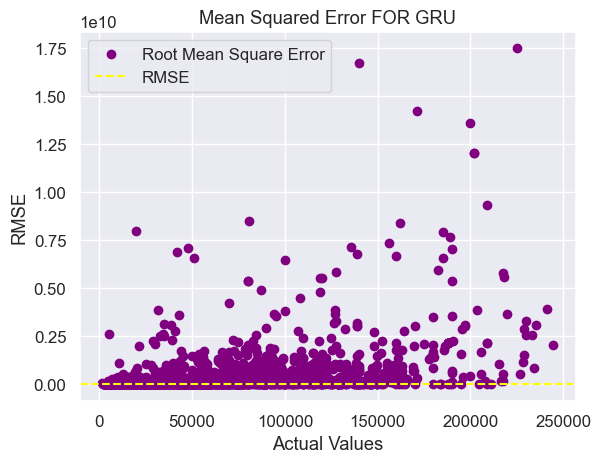

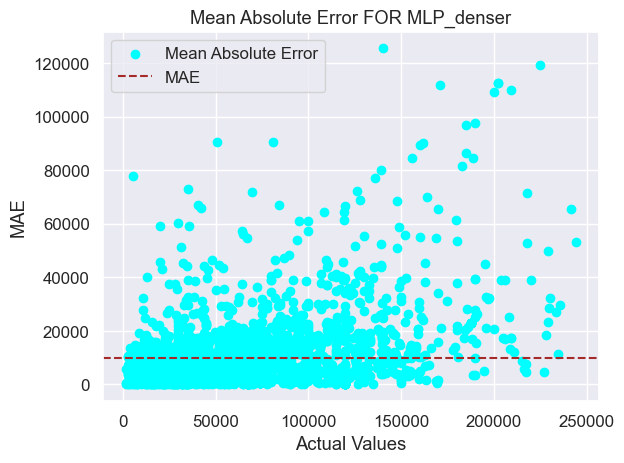

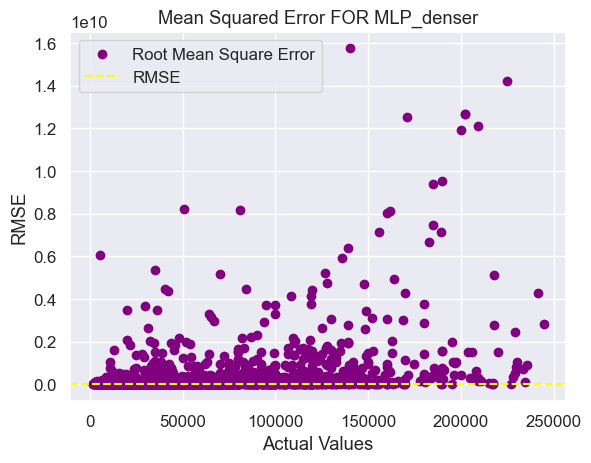

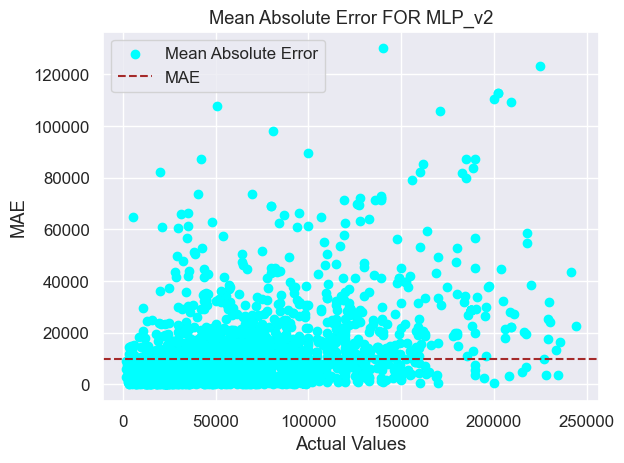

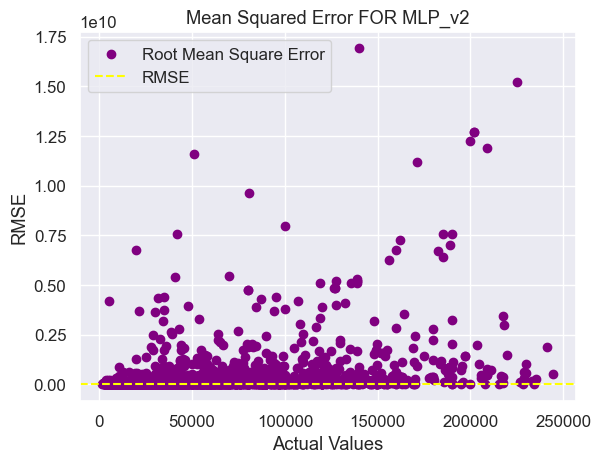

In [60]:
mae_rmse_plots(y_test_pred_LSTM, "LSTM", mae_test_LSTM, rmse_test_LSTM)
mae_rmse_plots(y_test_pred_MLP, "MLP", mae_test_MLP, rmse_test_MLP)
mae_rmse_plots(y_test_pred_GRU, "GRU", mae_test_GRU, rmse_test_GRU)
mae_rmse_plots(y_test_pred_MLP_n, "MLP_denser", mae_test_MLP_n, rmse_test_MLP_n)
mae_rmse_plots(y_test_pred_MLP_v2, "MLP_v2", mae_test_MLP_v2, rmse_test_MLP_v2)

Get the best hyperparameters

TODO: to fix

In [61]:
# from sklearn.model_selection import RandomizedSearchCV
#
# from keras.wrappers.scikit_learn import KerasRegressor
#
# # keras tuner
# # błąd procentowy
#
#
# def get_hyperparameters():
#         model = KerasRegressor(build_fn=LSTM_architecture, verbose=0)
#         param_grid = {
#             'neurons_lstm': [32, 64, 128],
#             'neurons_dense': [16, 32, 64],
#             'activation': ['relu'],
#             'l2_val': [0.01, 0.001, 0.0001]
#         }
#         searcher = RandomizedSearchCV(
#             estimator=model,
#             param_distributions=param_grid,
#             n_iter=5,
#             cv=3,
#             n_jobs=-1
#         )
#         searcher.fit(X_train_3D, y_train_scaled)
#         return searcher.best_params_, searcher.best_score_
#
# # Call the function to get the best hyperparameters
# best_params, best_score = get_hyperparameters()
#
# print("Best parameters: ", best_params)
# print("Best score: ", best_score)

Every possible combination of param_grid parameters.
TODO: Best parameters:  {'neurons_lstm': 64, 'neurons_dense': 32, 'l2_val': 0.0001, 'activation': 'relu'}
Best score:  -0.21322791775067648 <- completely wrong

In [62]:
# from sklearn.model_selection import GridSearchCV
#
# # definiowanie zestawów parametrów do przetestowania
# param_grid = {
#     'neurons_lstm': [64, 128],
#     'neurons_dense1': [32, 64],
#     'neurons_dense2': [16, 32],
#     'neurons_dense3': [8, 16],
#     'neurons_dense4': [8, 16],
#     'activation': ['relu', 'tanh'],
#     'l2_val': [0.01, 0.001],
#     'batch_size': [32, 64]
# }
#
#
# model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=MLP_architecture_v2, epochs=1, verbose=0)
#
# # start Grid Search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
#
# print(f"Best score: {grid_result.best_score_}")
# print(f"Best params: {grid_result.best_params_}")


### Possible DEPLOY
To deploy code in form of Docker we should probably enclose model into some kind of REST API for example.